In [2]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import sort
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

/home/jake/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/jake/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
# The config for the database
config = {
  'user': 'jake',
  'password': 'jake',
  'host': '127.0.0.1',
  'database': 'SportMaster',
  'raise_on_warnings': True,
}
cnx = mysql.connector.connect(**config)

In [60]:
#Personality
Personality = ("""SELECT 
    client_reg_code, 
    TIMESTAMPDIFF(YEAR, sm_clients.birthday, '2017-4-12') AS age, 
    sex,
    ismobile,
    isemail,
    place_shop,
    ADDR_CITY
FROM
    sm_clients
""")
Personality_df = pd.read_sql_query(Personality, cnx)
Personality_df.to_csv('dataset/Personality.csv', index = False)

In [8]:
#Geographically related

avgVisitors = ("""
SELECT 
    sm_clients.client_reg_code, t2.AverageVisitors
FROM
    sm_clients
        LEFT JOIN
    (SELECT 
        sm_shops_visitors.shop,
            AVG(sm_shops_visitors.visitors) AS AverageVisitors
    FROM
        sm_shops_visitors
    GROUP BY sm_shops_visitors.shop) t2 ON sm_clients.place_shop = t2.shop
""")

registerSQT_registerSQTtrade = ("""
SELECT 
    sm_clients.client_reg_code,
    t2.RegisterSQT,
    t2.Register_SQT_trade
FROM
    sm_clients
        LEFT JOIN
    (SELECT 
        sm_shops_sprav.shop,
            sm_shops_sprav.SQT AS RegisterSQT,
            sm_shops_sprav.SQT_trade AS Register_SQT_trade
    FROM
        sm_shops_sprav) t2 ON sm_clients.place_shop = t2.shop
""")

avgVisitors_df = pd.read_sql_query(avgVisitors, cnx)
registerSQT_registerSQTtrade_df = pd.read_sql_query(registerSQT_registerSQTtrade, cnx)

Geographical_df = avgVisitors_df\
.merge(registerSQT_registerSQTtrade_df, how = 'left', on='client_reg_code')

Geographical_df.to_csv('dataset/Geographical.csv', index = False)

In [35]:
Geographical_df.isnull().sum()

client_reg_code            0
AverageVisitors       150168
RegisterSQT            66259
Register_SQT_trade     66259
dtype: int64

In [15]:
#Consumption Record Overall

OverallAmount = ("""
SELECT 
    sm_checks.client_reg_code,
    SUM(sm_checks.`SUMMA_FULL`) AS OrginalPrice_in_total,
    SUM(sm_checks.`SUMMA_MONEY`) AS PayAmount_in_total,
    SUM(sm_checks.`SUMMA_BONUS`) AS UsedBonus_in_total,
    SUM(sm_checks.`SUMMA_DISCOUNT`) AS DiscountAmount_in_total,
    COUNT(sm_checks.`CHECK_LIST_CODE`) AS Product_Count,
    COUNT(sm_checks.`quantity`) AS Quantity_Count
FROM
    sm_checks
GROUP BY sm_checks.client_reg_code
""")

OverallAmount_AfterDec13 = ("""
SELECT 
    sm_checks.client_reg_code,
    ifnull(SUM(sm_checks.`SUMMA_FULL`), 0) AS OrginalPrice_in_total_AfterDec13,
    ifnull(SUM(sm_checks.`SUMMA_MONEY`), 0) AS PayAmount_in_total_AfterDec13,
    ifnull(SUM(sm_checks.`SUMMA_BONUS`), 0) AS UsedBonus_in_total_AfterDec13,
    ifnull(SUM(sm_checks.`SUMMA_DISCOUNT`), 0) AS DiscountAmount_in_total_AfterDec13,
    ifnull(COUNT(sm_checks.`CHECK_LIST_CODE`), 0) AS Product_Count_AfterDec13,
    ifnull(COUNT(sm_checks.`quantity`), 0) AS Quantity_Count_AfterDec13
FROM
    sm_checks
WHERE
    sm_checks.CHECK_DAT > '2013-12-01'
GROUP BY sm_checks.client_reg_code
""")

OverallAmount_AfterJun14 = ("""
SELECT 
    sm_checks.client_reg_code,
    ifnull(SUM(sm_checks.`SUMMA_FULL`), 0) AS OrginalPrice_in_total_AfterJun14,
    ifnull(SUM(sm_checks.`SUMMA_MONEY`), 0) AS PayAmount_in_total_AfterJun14,
    ifnull(SUM(sm_checks.`SUMMA_BONUS`), 0) AS UsedBonus_in_total_AfterJun14,
    ifnull(SUM(sm_checks.`SUMMA_DISCOUNT`), 0) AS DiscountAmount_in_total_AfterJun14,
    ifnull(COUNT(sm_checks.`CHECK_LIST_CODE`), 0) AS Product_Count_AfterJun14,
    ifnull(COUNT(sm_checks.`quantity`), 0) AS Quantity_Count_AfterJun14
FROM
    sm_checks
WHERE
    sm_checks.CHECK_DAT > '2014-06-01'
GROUP BY sm_checks.client_reg_code
""")

OverallAmount_df = pd.read_sql_query(OverallAmount, cnx)
OverallAmount_Dec13_df = pd.read_sql_query(OverallAmount_AfterDec13, cnx)
OverallAmount_Jun14_df = pd.read_sql_query(OverallAmount_AfterJun14, cnx)

Consumption_df = LeftjoinUser_df\
.merge(OverallAmount_df, how = 'left', on='client_reg_code')\
.merge(OverallAmount_Dec13_df, how = 'left', on='client_reg_code')\
.merge(OverallAmount_Jun14_df, how = 'left', on='client_reg_code')

Consumption_df.to_csv('dataset/Consumption.csv', index = False)

In [51]:
Consumption_df.shape

(4452055, 19)

In [57]:
Consumption_df.isnull().sum()

client_reg_code                             0
OrginalPrice_in_total                 1390740
PayAmount_in_total                    1390740
UsedBonus_in_total                    1390740
DiscountAmount_in_total               1390740
Product_Count                         1390740
Quantity_Count                        1390740
OrginalPrice_in_total_AfterDec13      1431425
PayAmount_in_total_AfterDec13         1431425
UsedBonus_in_total_AfterDec13         1431425
DiscountAmount_in_total_AfterDec13    1431425
Product_Count_AfterDec13              1431425
Quantity_Count_AfterDec13             1431425
OrginalPrice_in_total_AfterJun14      1758717
PayAmount_in_total_AfterJun14         1758717
UsedBonus_in_total_AfterJun14         1758717
DiscountAmount_in_total_AfterJun14    1758717
Product_Count_AfterJun14              1758717
Quantity_Count_AfterJun14             1758717
dtype: int64

In [30]:
#Consumption segmentation

SUMMA_full_Over_1000 = ("""
SELECT 
    sm_checks.client_reg_code,
    ifnull(COUNT(sm_checks.`SUMMA_full`), 0) AS SUMMA_full_Over_1000
FROM
    sm_checks
WHERE
    sm_checks.`SUMMA_full` > 1000
GROUP BY sm_checks.client_reg_code
""")

SUMMA_full_500_1000 = ("""
SELECT 
    sm_checks.client_reg_code,
    COUNT(sm_checks.`SUMMA_full`) AS SUMMA_full_500_1000
FROM
    sm_checks
WHERE
    (sm_checks.`SUMMA_full` > 500 and sm_checks.`SUMMA_full` < 1000)
GROUP BY sm_checks.client_reg_code
""")

SUMMA_full_500 = ("""
SELECT 
    sm_checks.client_reg_code,
    COUNT(sm_checks.`SUMMA_full`) AS SUMMA_full_500
FROM
    sm_checks
WHERE
    (sm_checks.`SUMMA_full` <= 500)
GROUP BY sm_checks.client_reg_code
""")

PurchasingMorethan500RubwithoutBonus = ("""
SELECT 
    sm_checks.client_reg_code,
    COUNT(sm_checks.`SUMMA_full`) AS PurchasingMorethan500RubwithoutBonus
FROM
    sm_checks
WHERE
    (sm_checks.`SUMMA_bonus` = 0 and sm_checks.`SUMMA_full` >= 500)
GROUP BY sm_checks.client_reg_code
""")

PurchasingMorethan1000RubwithoutBonus = ("""
SELECT 
    sm_checks.client_reg_code,
    COUNT(sm_checks.`SUMMA_full`) AS PurchasingMorethan1000RubwithoutBonus
FROM
    sm_checks
WHERE
    (sm_checks.`SUMMA_bonus` = 0 and sm_checks.`SUMMA_full` >= 1000)
GROUP BY sm_checks.client_reg_code
""")

PurchasingMorethan1500RubwithoutBonus = ("""
SELECT 
    sm_checks.client_reg_code,
    COUNT(sm_checks.`SUMMA_full`) AS PurchasingMorethan1500RubwithoutBonus
FROM
    sm_checks
WHERE
    (sm_checks.`SUMMA_bonus` = 0 and sm_checks.`SUMMA_full` >= 1500)
GROUP BY sm_checks.client_reg_code
""")

PurchasingMorethan500RubwithoutDiscount = ("""
SELECT 
    sm_checks.client_reg_code,
    COUNT(sm_checks.`SUMMA_full`) AS PurchasingMorethan500RubwithoutDiscount
FROM
    sm_checks
WHERE
    (sm_checks.`SUMMA_discount` = 0 and sm_checks.`SUMMA_full` >= 500)
GROUP BY sm_checks.client_reg_code
""")

PurchasingMorethan1000RubwithoutDiscount = ("""
SELECT 
    sm_checks.client_reg_code,
    COUNT(sm_checks.`SUMMA_full`) AS PurchasingMorethan1000RubwithoutDiscount
FROM
    sm_checks
WHERE
    (sm_checks.`SUMMA_discount` = 0 and sm_checks.`SUMMA_full` >= 1000)
GROUP BY sm_checks.client_reg_code
""")

PurchasingMorethan1500RubwithoutDiscount = ("""
SELECT 
    sm_checks.client_reg_code,
    COUNT(sm_checks.`SUMMA_full`) AS PurchasingMorethan1500RubwithoutDiscount
FROM
    sm_checks
WHERE
    (sm_checks.`SUMMA_discount` = 0 and sm_checks.`SUMMA_full` >= 1500)
GROUP BY sm_checks.client_reg_code
""")


SUMMA_full_Over_1000_df = pd.read_sql_query(SUMMA_full_Over_1000, cnx)
SUMMA_full_500_1000_df = pd.read_sql_query(SUMMA_full_500_1000, cnx)
SUMMA_full_500_df = pd.read_sql_query(SUMMA_full_500, cnx)

PurchasingMorethan500RubwithoutBonus_df = pd.read_sql_query(PurchasingMorethan500RubwithoutBonus, cnx)
PurchasingMorethan1000RubwithoutBonus_df = pd.read_sql_query(PurchasingMorethan1000RubwithoutBonus, cnx)
PurchasingMorethan1500RubwithoutBonus_df = pd.read_sql_query(PurchasingMorethan1500RubwithoutBonus, cnx)

PurchasingMorethan500RubwithoutDiscount_df = pd.read_sql_query(PurchasingMorethan500RubwithoutDiscount, cnx)
PurchasingMorethan1000RubwithoutDiscount_df = pd.read_sql_query(PurchasingMorethan1000RubwithoutDiscount, cnx)
PurchasingMorethan1500RubwithoutDiscount_df = pd.read_sql_query(PurchasingMorethan1500RubwithoutDiscount, cnx)

Consumption_Interval_df = LeftjoinUser_df\
.merge(SUMMA_full_Over_1000_df, how = 'left', on='client_reg_code')\
.merge(SUMMA_full_500_1000_df, how = 'left', on='client_reg_code')\
.merge(SUMMA_full_500_df, how = 'left', on='client_reg_code')\
.merge(PurchasingMorethan500RubwithoutBonus_df, how = 'left', on='client_reg_code')\
.merge(PurchasingMorethan1000RubwithoutBonus_df, how = 'left', on='client_reg_code')\
.merge(PurchasingMorethan1500RubwithoutBonus_df, how = 'left', on='client_reg_code')\
.merge(PurchasingMorethan500RubwithoutDiscount_df, how = 'left', on='client_reg_code')\
.merge(PurchasingMorethan1000RubwithoutDiscount_df, how = 'left', on='client_reg_code')\
.merge(PurchasingMorethan1500RubwithoutDiscount_df, how = 'left', on='client_reg_code')

Consumption_Interval_df.to_csv('dataset/Consumption_Interval_withifnull.csv', index = False)


In [146]:
# withleftjoin
Consumption_Interval_df.shape

(4452055, 10)

In [54]:
Consumption_Interval_df.isnull().sum()

client_reg_code                                   0
SUMMA_full_Over_1000                        2155800
SUMMA_full_500_1000                         2478875
SUMMA_full_500                              1839301
PurchasingMorethan500RubwithoutBonus        1904753
PurchasingMorethan1000RubwithoutBonus       2438192
PurchasingMorethan1500RubwithoutBonus       2772270
PurchasingMorethan500RubwithoutDiscount     2123286
PurchasingMorethan1000RubwithoutDiscount    2695763
PurchasingMorethan1500RubwithoutDiscount    3014695
dtype: int64

In [58]:
LeftjoinUser = ("""
SELECT 
    sm_clients.client_reg_code
FROM
    sm_clients
""")

LeftjoinUser_df = pd.read_sql_query(LeftjoinUser, cnx)

In [179]:
PurchaseRecordOnDay = ("""
SELECT 
    client_reg_code,
    COUNT(CASE WHEN WEEKDAY(CHECK_DAT) = 0 THEN 1 ELSE NULL END) AS PurchaseOnMonday,
    COUNT(CASE WHEN WEEKDAY(CHECK_DAT) = 1 THEN 1 ELSE NULL END) AS PurchaseOnTuesday,
    COUNT(CASE WHEN WEEKDAY(CHECK_DAT) = 2 THEN 1 ELSE NULL END) AS PurchaseOnWednesday,
    COUNT(CASE WHEN WEEKDAY(CHECK_DAT) = 3 THEN 1 ELSE NULL END) AS PurchaseOnThursday,
    COUNT(CASE WHEN WEEKDAY(CHECK_DAT) = 4 THEN 1 ELSE NULL END) AS PurchaseOnFriday,
    COUNT(CASE WHEN WEEKDAY(CHECK_DAT) = 5 THEN 1 ELSE NULL END) AS PurchaseOnSaturday,
    COUNT(CASE WHEN WEEKDAY(CHECK_DAT) = 6 THEN 1 ELSE NULL END) AS PurchaseOnSunday,
    COUNT(CASE WHEN (WEEKDAY(CHECK_DAT) = 0 or WEEKDAY(CHECK_DAT) = 1 or WEEKDAY(CHECK_DAT) = 2 or WEEKDAY(CHECK_DAT) = 3 or WEEKDAY(CHECK_DAT) = 4) THEN 1 ELSE NULL END) AS PurchaseOnWeekdays,
    COUNT(CASE WHEN (WEEKDAY(CHECK_DAT) = 5 or WEEKDAY(CHECK_DAT) = 6) THEN 1 ELSE NULL END) AS PurchaseOnWeekend,
    COUNT(CASE WHEN (time(CHECK_DAT) >= '04:00:00' and time(CHECK_DAT) < '07:00:00') THEN 1 ELSE NULL END) AS PurchaseOnDawn,
    COUNT(CASE WHEN (time(CHECK_DAT) >= '07:00:00' and time(CHECK_DAT) < '11:00:00') THEN 1 ELSE NULL END) AS PurchaseOnAMPeak,
    COUNT(CASE WHEN (time(CHECK_DAT) >= '11:00:00' and time(CHECK_DAT) < '18:00:00') THEN 1 ELSE NULL END) AS PurchaseOnMidDay,
    COUNT(CASE WHEN (time(CHECK_DAT) >='18:00:00' and time(CHECK_DAT) < '21:00:00') THEN 1 ELSE NULL END) AS PurchaseOnPMPeak,
    COUNT(CASE WHEN (time(CHECK_DAT) >= '21:00:00' or time(CHECK_DAT) < '04:00:00') THEN 1 ELSE NULL END) AS PurchaseOnEvening
FROM
    SportMaster.sm_checks
GROUP BY client_reg_code
""")

PurchaseRecordOnDay_df = pd.read_sql_query(PurchaseRecordOnDay, cnx)
PurchaseRecordOnDay_df.to_csv('dataset/PurchaseRecordOnDay.csv', index = False)

In [181]:
PurchaseRecordOnDay_df.head()

,client_reg_code,PurchaseOnMonday,PurchaseOnTuesday,PurchaseOnWednesday,PurchaseOnThursday,PurchaseOnFriday,PurchaseOnSaturday,PurchaseOnSunday,PurchaseOnWeekdays,PurchaseOnWeekend,PurchaseOnDawn,PurchaseOnAMPeak,PurchaseOnMidDay,PurchaseOnPMPeak,PurchaseOnEvening
0,121000000000074432,0,7,0,0,0,0,0,7,0,0,0,0,0,7
1,121000000000093516,0,0,0,1,0,0,2,1,2,0,0,2,0,1
2,121000000000096110,2,0,1,3,2,1,3,8,4,0,0,3,2,7
3,121000000000106707,0,2,0,0,0,0,0,2,0,0,0,2,0,0
4,121000000000109529,3,0,2,0,0,0,3,5,3,0,0,2,3,3


In [206]:
#MergeAll

MergeAllDataset_df = Personality_df\
.merge(Geographical_df, how = 'left', on='client_reg_code')\
.merge(Consumption_df, how = 'left', on='client_reg_code')\
.merge(Consumption_Interval_df, how = 'left', on='client_reg_code')\
.merge(PurchaseRecordOnDay_df, how = 'left', on='client_reg_code')

MergeAllDataset_df.to_csv('dataset/OriginalDataset.csv', index = False)


In [4]:
MergeAllDataset_df = pd.read_csv('dataset/OriginalDataset.csv')

In [5]:
MergeAllDataset_df.shape

(4452055, 51)

In [7]:
MergeAllDataset_df.isnull().sum()

client_reg_code                             0
age                                         0
sex                                         0
ismobile                                    0
isemail                                     0
place_shop                                  0
ADDR_CITY                                   0
AverageVisitors                             0
RegisterSQT                                 0
Register_SQT_trade                          0
OrginalPrice_in_total                       0
PayAmount_in_total                          0
UsedBonus_in_total                          0
DiscountAmount_in_total                     0
Product_Count                               0
Quantity_Count                              0
OrginalPrice_in_total_AfterDec13            0
PayAmount_in_total_AfterDec13               0
UsedBonus_in_total_AfterDec13               0
DiscountAmount_in_total_AfterDec13          0
Product_Count_AfterDec13                    0
Quantity_Count_AfterDec13         

In [6]:
MergeAllDataset_df.loc[:,'age':'PurchaseOnEvening'] = MergeAllDataset_df.loc[:,'age':'PurchaseOnEvening'].fillna(0)

In [8]:
MergeAllDataset_df = MergeAllDataset_df.drop("ADDR_CITY",1)

/home/jake/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


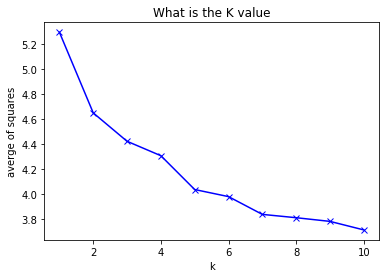

In [22]:
%matplotlib inline
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import preprocessing
MergeAllDataset_df_scaled = preprocessing.scale(MergeAllDataset_df)
X = MergeAllDataset_df_scaled
K = range(1, 11)
meandistortions = []
for k in K:
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    meandistortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
plt.figure()
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('averge of squares')
plt.title('What is the K value');

In [9]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
MergeAllDataset_df_scaled = preprocessing.scale(MergeAllDataset_df)
k_means = KMeans(n_clusters = 5)
y_pred = k_means.fit_predict(MergeAllDataset_df_scaled)

/home/jake/anaconda3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [47]:
pd.set_option('display.float_format', '{:.20g}'.format)

In [53]:
for i in range(5):
    print('cluster' + repr(i))
    print(MergeAllDataset_df.iloc[np.where(y_pred == i)[0].tolist()].shape[0])
    print(MergeAllDataset_df.iloc[np.where(y_pred == i)[0].tolist()].mean())

cluster0
2536203
client_reg_code                                   698205595859805696
age                                            32.978533264095972299
sex                                           0.43427123144322438142
ismobile                                      0.74485480854647678761
isemail                                      0.060691514046785688397
place_shop                                     2507.3405228209257984
AverageVisitors                                1419.4858558619321229
RegisterSQT                                    1504.8764753074790406
Register_SQT_trade                              1246.322969225280076
OrginalPrice_in_total                           2401.749160536447107
PayAmount_in_total                             1909.3526258189951932
UsedBonus_in_total                             90.274943685501511936
DiscountAmount_in_total                        402.12159103194886711
Product_Count                                  2.3832800450121696123
Quantity_Count   

In [24]:
cluster2_index = np.where(y_pred == 2)[0].tolist()

In [27]:
cluster2_df = MergeAllDataset_df.iloc[cluster2_index]

In [39]:
cluster2_df.mean()

client_reg_code                             7.200169e+17
age                                         3.767523e+01
sex                                         3.890670e-01
ismobile                                    9.028518e-01
isemail                                     1.398923e-01
place_shop                                  2.645840e+03
AverageVisitors                             1.519825e+03
RegisterSQT                                 2.096621e+03
Register_SQT_trade                          1.773951e+03
OrginalPrice_in_total                       2.037263e+04
PayAmount_in_total                          1.533224e+04
UsedBonus_in_total                          1.302009e+03
DiscountAmount_in_total                     3.738377e+03
Product_Count                               1.635822e+01
Quantity_Count                              1.635822e+01
OrginalPrice_in_total_AfterDec13            1.982144e+04
PayAmount_in_total_AfterDec13               1.485504e+04
UsedBonus_in_total_AfterDec13  

In [30]:
cluster1_index = np.where(y_pred == 1)[0].tolist()

In [31]:
cluster1_df = MergeAllDataset_df.iloc[cluster1_index]

In [32]:
cluster1_df.describe()

,client_reg_code,age,sex,ismobile,isemail,place_shop,AverageVisitors,RegisterSQT,Register_SQT_trade,OrginalPrice_in_total,...,PurchaseOnFriday,PurchaseOnSaturday,PurchaseOnSunday,PurchaseOnWeekdays,PurchaseOnWeekend,PurchaseOnDawn,PurchaseOnAMPeak,PurchaseOnMidDay,PurchaseOnPMPeak,PurchaseOnEvening
count,2.625700e+04,26257.000000,26257.00000,26257.000000,26257.000000,26257.000000,26257.000000,26257.000000,26257.000000,2.625700e+04,...,26257.000000,26257.000000,26257.000000,26257.000000,26257.000000,26257.000000,26257.000000,26257.000000,26257.000000,26257.000000
mean,8.923178e+17,40.863122,0.34467,0.926762,0.293369,2149.306775,1454.923687,2126.221198,1782.609392,1.389335e+05,...,12.348593,20.394942,19.787104,53.064668,40.182047,0.007769,1.460563,33.912823,13.822295,44.043265
std,2.772897e+17,34.387634,0.47527,0.260531,0.455315,2109.962526,569.698858,1254.443786,1126.389215,6.738188e+04,...,10.483651,14.983711,14.565092,30.671957,23.399979,0.382649,3.512814,21.961800,13.386731,25.438050
min,1.210000e+17,0.000000,0.00000,0.000000,0.000000,244.000000,0.000000,0.000000,0.000000,4.792100e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.920000e+17,35.000000,0.00000,1.000000,0.000000,723.000000,1062.705600,1329.000000,1071.800000,1.030380e+05,...,5.000000,10.000000,10.000000,35.000000,24.000000,0.000000,0.000000,19.000000,4.000000,30.000000
50%,9.920000e+17,40.000000,0.00000,1.000000,0.000000,868.000000,1464.356300,1579.900000,1300.000000,1.221460e+05,...,10.000000,18.000000,17.000000,49.000000,37.000000,0.000000,0.000000,31.000000,11.000000,40.000000
75%,9.920000e+17,45.000000,1.00000,1.000000,1.000000,5052.000000,1837.546700,2444.000000,2071.300000,1.534520e+05,...,17.000000,27.000000,27.000000,64.000000,52.000000,0.000000,2.000000,44.000000,20.000000,52.000000
max,9.920000e+17,1949.000000,1.00000,1.000000,1.000000,6018.000000,3295.462600,5805.000000,4895.000000,1.439694e+06,...,146.000000,185.000000,190.000000,642.000000,318.000000,40.000000,146.000000,496.000000,216.000000,581.000000


In [11]:
k_means.labels_

array([2, 2, 3, ..., 0, 3, 0], dtype=int32)

In [12]:
y_pred

array([2, 2, 3, ..., 0, 3, 0], dtype=int32)

In [13]:
{i: np.where(y_pred == i)[0] for i in range(k_means.n_clusters)}

{0: array([      3,      10,      13, ..., 4452050, 4452052, 4452054]),
 1: array([     69,      74,     174, ..., 4451722, 4451747, 4451905]),
 2: array([      0,       1,       4, ..., 4451980, 4451987, 4452005]),
 3: array([      2,       5,       8, ..., 4452049, 4452051, 4452053]),
 4: array([     37,      39,      48, ..., 4451961, 4452022, 4452024])}

In [45]:
X = MergeAllDataset_df.as_matrix()

In [49]:
{i: MergeAllDataset_df.as_matrix()[np.where(y_pred == i)][0] for i in range(k_means.n_clusters)}

{0: array([  9.92000000e+17,   4.50000000e+01,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   7.20000000e+02,
          1.75170440e+03,   4.61900000e+03,   3.70900000e+03,
          2.34910000e+04,   1.18863000e+04,   3.05000000e+02,
          1.12997000e+04,   9.00000000e+00,   9.00000000e+00,
          2.34910000e+04,   1.18863000e+04,   3.05000000e+02,
          1.12997000e+04,   9.00000000e+00,   9.00000000e+00,
          2.16950000e+04,   1.03953000e+04,   0.00000000e+00,
          1.12997000e+04,   5.00000000e+00,   5.00000000e+00,
          4.00000000e+00,   3.00000000e+00,   2.00000000e+00,
          6.00000000e+00,   4.00000000e+00,   4.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          4.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   7.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.00000000e+00,
     

In [47]:
cluster_0 = np.where(y_pred == 0)

In [48]:
cluster_0

(array([      0,       1,       4, ..., 4451980, 4451987, 4452005]),)

In [32]:
MergeAllDataset_df[cluster_0]

TypeError: unhashable type: 'numpy.ndarray'

In [25]:
for i in range(5):
    index = np.nonzero(y_pred == i)[0]
    x = MergeAllDataset_df[index, ]
    break
print(x)

TypeError: unhashable type: 'numpy.ndarray'

In [204]:
MergeAllDataset_df['PurchaseOnDawn'].describe()

count    4.452055e+06
mean     1.680123e-04
std      3.944753e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.000000e+01
Name: PurchaseOnDawn, dtype: float64

In [207]:
MergeAllDataset_df.update(MergeAllDataset_df[['PurchaseOnDawn','PurchaseOnAMPeak','PurchaseOnMidDay']].fillna(0))

In [208]:
MergeAllDataset_df['PurchaseOnDawn'].describe()

count    4.452055e+06
mean     1.680123e-04
std      3.944753e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.000000e+01
Name: PurchaseOnDawn, dtype: float64

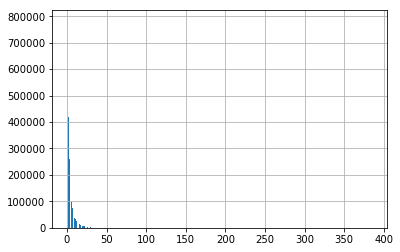

In [120]:
%matplotlib inline
dataset_df['SUMMA_full_Over_1000'].hist(bins = 805)

In [139]:
#Split the dataset into X, and Y
Y = dataset_df["Label"]
X = dataset_df.drop("Label",1)
X = X.drop("PayAmount_in_total",1)
X = X.drop("OrginalPrice_in_total",1)
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

In [140]:
model = xgboost.XGBClassifier(n_estimators = 50)
model.fit(X_train, y_train, eval_metric = "mlogloss", eval_set = [(X_test, y_test)], verbose=True, early_stopping_rounds = 5)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
probs = model.predict_proba(X_test)

[0]	validation_0-mlogloss:1.37567
Will train until validation_0-mlogloss hasn't improved in 5 rounds.
[1]	validation_0-mlogloss:1.19579
[2]	validation_0-mlogloss:1.05068
[3]	validation_0-mlogloss:0.93017
[4]	validation_0-mlogloss:0.828104
[5]	validation_0-mlogloss:0.740531
[6]	validation_0-mlogloss:0.664641
[7]	validation_0-mlogloss:0.598387
[8]	validation_0-mlogloss:0.540065
[9]	validation_0-mlogloss:0.488617
[10]	validation_0-mlogloss:0.44307
[11]	validation_0-mlogloss:0.402611
[12]	validation_0-mlogloss:0.366598
[13]	validation_0-mlogloss:0.334435
[14]	validation_0-mlogloss:0.305616
[15]	validation_0-mlogloss:0.279853
[16]	validation_0-mlogloss:0.256773
[17]	validation_0-mlogloss:0.236012
[18]	validation_0-mlogloss:0.21737
[19]	validation_0-mlogloss:0.200541
[20]	validation_0-mlogloss:0.185402
[21]	validation_0-mlogloss:0.171796
[22]	validation_0-mlogloss:0.159523
[23]	validation_0-mlogloss:0.148451
[24]	validation_0-mlogloss:0.138322
[25]	validation_0-mlogloss:0.129204
[26]	validat

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99    230348
        1.0       0.97      0.99      0.98    229035
        2.0       0.97      0.97      0.97    229221
        3.0       1.00      0.97      0.99    229569
        4.0       1.00      1.00      1.00    417444

avg / total       0.99      0.99      0.99   1335617



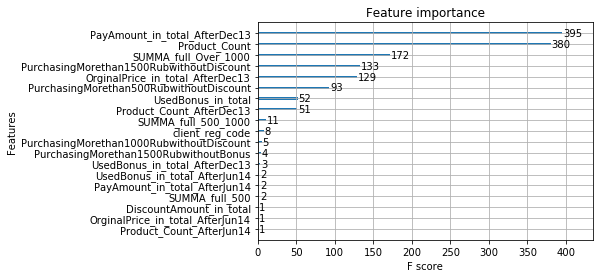

In [141]:
print(metrics.classification_report(y_test, predictions)) 
plot_importance(model)